<h1 align="center">Generalized Linear Model</h1> 
<h3 align="center">BSAI course, Autumn, 2025</h3> 

In this tutorial we will go over some basic concepts and implementations of the Generalized Linear Models (GLMs). 

Reference:

- [Neuromatch GLM tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Intro.html) The first three section of this tutorial mainly adapted from the GLM tutorial provided by Neuromatch Academy.

- [Cosyne 2018 GLM tutorial](https://www.youtube.com/watch?v=NFeGW5ljUoI) Section 4 of this tutorial is mainly inspired by the GLM tutorial of Jonathan Pillow in Cosyne 2018.

### Setup

First we import some packages and setup some plotting functions.

In [1]:
# Imports

import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize

In [2]:
# Plotting Functions

def plot_spikes_with_prediction(spikes, predicted_spikes, dt=None, nt=50, t0=120, show=True, **kws):
  t = np.arange(t0, t0 + nt)
  if dt is not None: t = t * dt
  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[t0:t0 + nt])
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[t0:t0 + nt], **kws)

  ax.set(
      xlabel="Image index" if dt is None else "Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  if show:
    plt.show()

def plot_spikes_with_multiple_predictions(spikes, predicted_list, dt=None,
                                          nt=50, t0=120, show=True, labels=None, colors=None, **kws):
    t = np.arange(t0, t0 + nt)
    if dt is not None: t = t * dt
    f, ax = plt.subplots()
    lines = ax.stem(t, spikes[t0:t0 + nt])
    plt.setp(lines, color=".5")
    lines[-1].set_zorder(1)
    if labels is None:
        labels = [f"Predicted {i+1}" for i in range(len(predicted_list))]
    if colors is None:
        colors = [None] * len(predicted_list)
    kws.setdefault("linewidth", 3)
    plot_handles = [lines[0]]
    legend_labels = ["Spikes"]
    for yhat, label, color in zip(predicted_list, labels, colors):
        handle, = ax.plot(t, yhat[t0:t0 + nt], label=label, color=color, **kws)
        plot_handles.append(handle)
        legend_labels.append(label)
    ax.set(
        xlabel="Image index" if dt is None else "Time (s)",
        ylabel="Spikes",
    )
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.legend(plot_handles, legend_labels)
    if show:
        plt.show()

def plot_spike_filter(theta, dt, show=True, **kws):
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )
  if show:
    plt.show()

def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )
    plt.show()

def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="C",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="C",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")
  plt.show()

## 1. Linear Gaussian Model</h2>

In linear model, we find a parameter $\bm{\theta}$ (vector) to map input $\bm{x_i}$ (vector) to ouptut $\hat{y_i}$ (scalar) for each sample $i$, which can be formatted as

$$\hat{y_i} = \bm{\theta}^T\bm{x_i}$$

Linear Gaussian model adds Gaussian noise in this progress to better depict the randomness of $\hat{y_i}$:

$$\hat{y_i} = \bm{\theta}^T\bm{x_i} + \eta_i, \quad \eta_i \sim \mathcal{N}(0, \sigma^2), \forall i$$

Note that here we take $\sigma$ as a hyperparameter, which is determined in advance and we do not search it for best predicting performance.

Given $n$ samples, we collate the data as a vectorized version. We define $\bm{X}$ which takes $\bm{x_i}$ as rows, and define $\bm{\hat{y}}=\begin{pmatrix}\hat{y_1}\\ \vdots \\ \hat{y_n}\end{pmatrix}$, $\bm{\theta}=\begin{pmatrix}\theta_1\\ \vdots \\ \theta_n\end{pmatrix}$, $\bm{\bm{\eta}}=\begin{pmatrix}\eta_1\\ \vdots \\ \eta_n\end{pmatrix}$, and $\bm{\Sigma}=\sigma\bm{I}$. Then the linear Gaussian model can be formatted as:

$$\hat{\bm{y}} = \bm{X\theta} + \bm{\eta}, \quad {\eta} \sim \mathcal{N}(\bm{0}, \bm{\Sigma}^2)$$

### (1) Retinal ganglion cell (RGC) dataset
In this section we use the public dataset from the Gollisch lab. It contains spike trains from 156 retinal ganglion cells of isolated salamander retina recorded while presenting 303 natural images. We will use these data to build simple encoding/decoding GLM models.

- Source [GIN/G-Node](https://gin.g-node.org/gollischlab/Liu_Gollisch_2021_RGC_spiketrains_spatial_contrast_model) (you can see details of this dataset here)
- File used here: `rgc_data.h5` (corresponds to `response2naturalimages.h5` in the GIN/G-Node repository)
- Variables:
  - `spikes`: (156, 303, 13, 300)
    - 156 neurons × 303 images × 13 repeated trials × 300 time bins
    - The value is binary (0 or 1), indicating whether there is a spike
  - `images`: (303, 256, 256)
    - 303 grayscale images of size 256×256
  - `resolution`: we set resolution = 0.001 seconds/bin (1 ms)

This dataset is already uploaded to the cloud of this course. If you want to manually download it from the [GIN/G-Node](https://gin.g-node.org/gollischlab/Liu_Gollisch_2021_RGC_spiketrains_spatial_contrast_model) website, please download the `response2naturalimages.h5` to current directory and rename it to `rgc_data.h5`.

In [3]:
def load_rgc_data():
  """
  data:
    - spikes: (156, 303, 13, 300)
    - images: (303, 256, 256)
    - mu: (156, 2)
    - sigma: (156, 2, 2)
    - resolution: 0.001
  """
  base_path = "10.12751_g-node.kod28e"
  f = h5py.File(f'{base_path}/responses2naturalimages.h5', 'r')
  data = {}
  for key in f.keys():
     data[key] = np.array(f[key])
  f.close()
  data['resolution'] = 0.001
  del data['mu']
  del data['sigma']
  return data

rgc_data = load_rgc_data()
print("Data keys:", list(rgc_data.keys()))
for key, item in rgc_data.items():
    print(f"  {key}: {item.shape if isinstance(item, np.ndarray) else item}")

Data keys: ['images', 'spikes', 'resolution']
  images: (303, 256, 256)
  spikes: (156, 303, 13, 300)
  resolution: 0.001


We check some images.

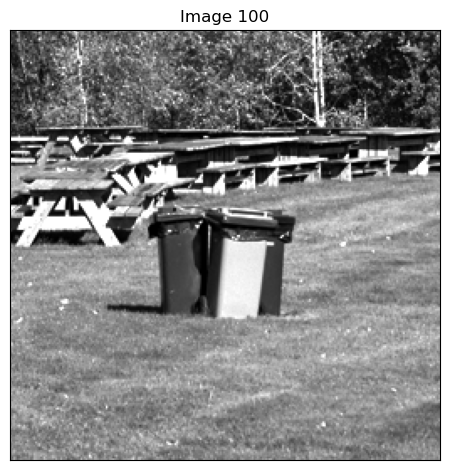

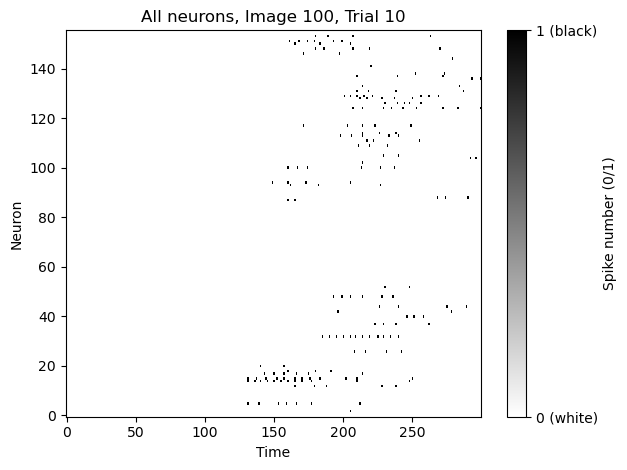

In [4]:
# you can change these values to view different images and trials
image_id = 100 # 0 ~ 302
trial_id = 10 # 0 ~ 12

plt.figure()
plt.imshow(np.transpose(rgc_data['images'][image_id, :, :]), cmap='gray', vmin=-1, vmax=1, origin='lower')
plt.title(f"Image {image_id}")
plt.xticks([])
plt.yticks([])
plt.tight_layout()

fig, ax = plt.subplots()
spike_mat_raw = rgc_data['spikes'][:, image_id, trial_id, :]  # shape: (n_neurons, n_timebins)
spike_mat = (spike_mat_raw > 0).astype(float)
im = ax.imshow(spike_mat, aspect='auto', origin='lower', interpolation='nearest', cmap='gray_r', vmin=0, vmax=1)
ax.set_xlabel('Time')
ax.set_ylabel('Neuron')
ax.set_title(f"All neurons, Image {image_id}, Trial {trial_id}")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Spike number (0/1)')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0 (white)', '1 (black)'])
plt.tight_layout()

For simplicity, we downsample the image from 256\*256 to 16\*16 as `stim_data`, and take the sum of spikes across the trial to each image as `spike_data`, mean over trials.

In [5]:
def collate_rgc_data_1(imagedata, spikedata):
    """
    Downsample the image from 256*256 to 16*16.
    Mean spikes over trials, then sum over time bins.
    Args:
      imagedata: (303, 256, 256)
      spikedata: (156, 303, 13, 300)
    Return:
      stim_data: (303, 16*16)
      spike_data: (303, 156)
    """
    stim_data = imagedata.reshape(303, 16, int(256/16), 16, int(256/16)).mean(axis=3).mean(axis=1) # (303, 16, 16)
    spike_data = spikedata.mean(axis=2).sum(axis=2).transpose(1,0) # (303, 156)
    return stim_data, spike_data

# collate rgc data
stim_data, spike_data = collate_rgc_data_1(rgc_data['images'], rgc_data['spikes'])
print(f"stim_data shape: {stim_data.shape}, spike_data.shape: {spike_data.shape}")

stim_data shape: (303, 16, 16), spike_data.shape: (303, 156)


### (2) Create design matrix

We use Linear Gaussian model as an `encoding model`, which means the model maps the stimulus to the corresponding neural activities. For the rgc dataset, the images are the input samples $\bm{x_i}$, and averaged total spike counts of a neuron during a trial of an image are the output samples $\bm{y_i}$.

Recall $\hat{\bm{y}} = \bm{X\theta} + \bm{\eta}, \quad {\eta} \sim \mathcal{N}(\bm{0}, \bm{\Sigma}^2)$, where $\bm{X}$ takes input samples $\bm{x_i}$ as rows. Here we call $\bm{X}$ the `design matrix`.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 1.1:</b>

Try building the `design matrix` $\bm{X}$.
</div>

In [6]:
def make_design_matrix(stim):
    """
    Args:
      stim: (303, 16, 16)
    Return:
      X: the design matrix, take each row as a sample
    """
    # X = ... # Your code here
    X = stim.reshape(stim.shape[0], -1)
    return X

design_matrix = make_design_matrix(stim_data)
print(design_matrix.shape)

(303, 256)


### (3) Solve linear Gaussian model

To accuratly predict spike counts from the stimulus images, we need to adjust the parameter $\bm{\theta}$ to minimize the discripency between the predicted spike counts $\hat{\bm{y}}$ and the true spike counts $\bm{y}$.

---

On the one hand, we could minimize the square error between the expected prediction ($\bm{X\theta}$) and the truth ($\bm{y}$). We call this method **Least Squares Estimation (LSE)**.

$$\bm{\theta^*} = \argmin\limits_{\theta}\parallel\bm{X\theta-y}\parallel_2^2 = \argmin\limits_{\theta}\sum\limits_{t=1}^{T}(y_t-\bm{\theta^Tx_t})^2$$

By setting the differential of $\bm{\theta}$ to zero, we could find local minima of the function.

$$
\begin{align*}
\frac{\partial\|X\boldsymbol{\theta}-\boldsymbol{y}\|_2^2}{\partial\boldsymbol{\theta}}&=2X^\top(X\boldsymbol{\theta}-\boldsymbol{y})=0\\
\Rightarrow\qquad\qquad\boldsymbol{\theta}_{\mathrm{LSE}}&=(X^\top X)^{-1}X^\top\boldsymbol{y}
\end{align*}
$$

---

On the other hand, we could get $\bm{\theta}$ by maximizing the log likelihood of $\bm{\theta}$ given data pair $(\bm{X}, \bm{y})$. We call this method **Maximize Likelihood Estimation (MLE)**.

Recall that the Gaussian probability function is:

$${\rm P_{Gaussian}}(\bm{x}|\bm{\mu},\bm{\Sigma})=\frac{1}{\sqrt{(2\pi)^k|\bm{\Sigma}|}}\exp{(-\frac{1}{2}(\bm{x-\mu})\bm{\Sigma}^{-1}(\bm{x-\mu}))}$$

The likelihood $L(\bm{\theta}|\bm{X,y}) = {\rm P_{Gaussaion}(\bm{y|X,\theta})}$, then we have:

$$
\begin{align*}
\bm{\theta^*} &= \argmax\limits_{\theta}\log L(\bm{\theta|X,y})\\
&= \argmax\limits_{\theta}[-\frac{N}{2}\log 2\pi\sigma^2 - \frac{1}{2\sigma^2}(\bm{y-X\theta})^T(\bm{y-X\theta})]
\end{align*}
$$
where $N$ is the dimensionality of $\bm{y}$ (the number of images).

$$
\begin{align*}
\frac{\partial\log L(\bm{\theta|X,y})}{\partial\boldsymbol{\theta}}&=-\frac{1}{\sigma^2}\bm{X^T}(\bm{X\theta-y})=0\\
\Rightarrow\qquad\qquad\boldsymbol{\theta}_{\mathrm{MLE}}&=(X^\top X)^{-1}X^\top\boldsymbol{y}
\end{align*}
$$

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 1.2:</b>

Try implementing the linear Gaussian model.
</div>

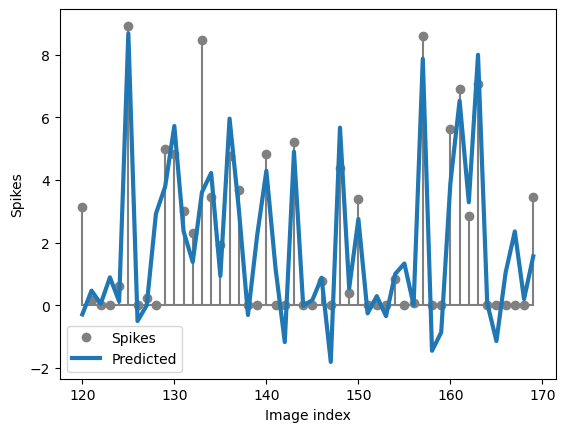

In [7]:
def predict_spike_counts_lg(stim, spikes):
  # Create the design matrix
  y = spikes
  # X = ... # your code here
  X = make_design_matrix(stim)

  # Get the MLE weights for the LG model
  # theta = ... # your code here
  theta = np.linalg.inv(X.T @ X) @ X.T @ y

  # Compute predicted spike counts
  yhat = X @ theta

  return yhat, theta

neuron_id = 5
# Predict spike counts
yhat_lg, theta_lg = predict_spike_counts_lg(stim_data, spike_data[:, neuron_id])
# Visualize
plot_spikes_with_prediction(
  spike_data[:, neuron_id], yhat_lg, nt=50, t0=120, color="C0")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 1.3:</b>

We could add bias to the prediction to better predict spike counts.

To be specific, we change $\hat{\bm{y}} = \bm{X\theta} + \bm{\eta}$ to $\hat{\bm{y}} = \bm{X\theta} + \bm{b} + \bm{\eta}$.

Actually, for simplicity of implementation, we could change $\bm{x_i}$ to $\begin{pmatrix}1\\ x_{i,1}\\ \vdots \\ x_{i,d}\end{pmatrix}$ (where $d$ is the dimensionality of $\bm{x_i}$). The $\bm{\theta}$ will be correspondingly changed to $\begin{pmatrix}b\\ \theta_1\\ \vdots \\ \theta_d\end{pmatrix}$.

</div>

bias: 1.869


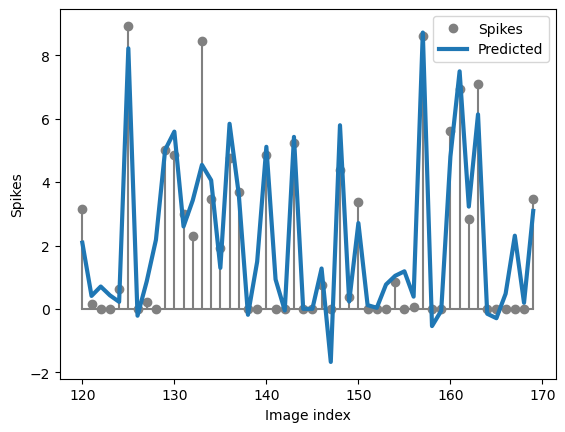

In [8]:
def predict_spike_counts_lg(stim, spikes):
  # Create the design matrix
  y = spikes
  constant = np.ones((len(y), 1))
  # X = ... # your code here
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Get the MLE weights for the LG model
  # theta_with_bias = ... # your code here
  theta_with_bias = np.linalg.inv(X.T @ X) @ X.T @ y

  # Compute predicted spike counts
  yhat = X @ theta_with_bias

  bias = theta_with_bias[0]
  theta = theta_with_bias[1:]
  return yhat, theta, bias

neuron_id = 5
# Predict spike counts
yhat_lg_2, theta_lg_2, bias_lg_2 = predict_spike_counts_lg(stim_data, spike_data[:, neuron_id])
# Visualize
print(f"bias: {bias_lg_2:.3f}")
plot_spikes_with_prediction(
  spike_data[:, neuron_id], yhat_lg_2, nt=50, t0=120, color="C0")

## 2. Poisson GLM

The Poisson GLM is also called the **LNP (Linear–Nonlinear–Poisson)** model. We first apply a linear filter to the input (Linear), pass the result through a nonlinearity to obtain a nonnegative firing rate (Nonlinear), and then model spike counts with a Poisson distribution (Noise).

In general, a GLM is of such linear-nonlinear-noise structure, therefore GLM is also called **cascade model**. Here the nonlinear function is called **nonlinearity**, and its reverse is called **link function**.

Here we conduct MLE for Poisson GLM. Let the design matrix be $\mathbf{X} \in \mathbb{R}^{n\times d}$ and the parameters (filter weights) be $\theta \in \mathbb{R}^{d}$. For sample $i$, the linear term is $\mathbf{x}_i^{\top}\theta$, and the rate after the exponential nonlinearity is $\lambda_i = \exp(\mathbf{x}_i^{\top}\theta)$. We assume the observed spike count $y_i$ follows

$$y_i \sim \text{Poisson}(\lambda_i), \quad P(y_i\mid\mathbf{x}_i,\theta) = \dfrac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i!}$$

The log-likelihood over all bins is

$$\log P(\mathbf{y}\mid\mathbf{X},\theta) = \sum_{i=1}^n \big[y_i\log\lambda_i - \lambda_i - \log(y_i!)\big], \quad \lambda_i = \exp(\mathbf{x}_i^{\top}\theta)$$

Since $\log(y_i!)$ does not depend on $\theta$, we can drop it for optimization. We denote log likelihood as $\ell$. In matrix form (with elementwise $\exp$ and $\log$) we have:

$$\ell(\theta) = \mathbf{y}^{\top}\log\boldsymbol{\lambda} - \mathbf{1}^{\top}\boldsymbol{\lambda}, \quad \boldsymbol{\lambda} = \exp(\mathbf{X}\theta)$$

We minimize the negative log-likelihood (NLL):

$$\mathcal{L}(\theta) = -\ell(\theta) = -\mathbf{y}^{\top}\log\boldsymbol{\lambda} + \mathbf{1}^{\top}\boldsymbol{\lambda}$$

### (1) Get negative log-likelihood

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 2.1:</b>

Try implementing the negative log likelihood used here ($\exp$ nonlinearity + Poisson noise).
</div>

In [9]:
def neg_log_lik_lnp(theta, X, y):
  # Compute the Poisson negative log likelihood
  # rate = ... # your code here
  # log_lik = ... # your code here
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - np.ones_like(rate).T @ rate

  return -log_lik

example_X = np.array([[1, 0.5], [1, 1.0], [1, 1.5]])
example_y = np.array([0, 1, 2])
print(neg_log_lik_lnp(np.zeros(example_X.shape[1]), example_X, example_y))

3.0


Now we need to solve this optimization problem for the negative log-likelihood. Unlike the linear Gaussian Model, there is no closed-form solution here, so we need to use numerical optimization methods to solve the problem.

### (2) Optimization methods

`scipy.optimize.minimize` (we have imported it as `minimize` at the beginning of this tutorial) is a general-purpose optimizer for unconstrained and constrained optimization problems.

A basic signature for usage: minimize(func, x0, args)

 Conceptually, you provide:
- an objective function `func(theta, *args)` that returns a scalar (the value to minimize),
- an initial guess `x0`,
- the arguments `args` which corresponding to `func(theta, *args)`

---

When using numerical optimization methods, we need to be cautious that the solver may be caught in a **local minimum**.

A local minimum is a point where the objective is lower than all nearby points, but not necessarily the lowest value overall. In contrast, a global minimum is the lowest value over the entire domain. In non‑convex problems, the surface can have many local minima/saddles, and different starting points can end up in different solutions.

Below we check examples to better understand the concept of local minima.
- For a simple convex quadratic like $f(x)=x^2$, different starting points converge to the same optimum but may take different paths/iterations.
- For an oscillatory, non‑convex function like $g(x)=x/5+\cos x$, different starting points can land in different basins of attraction (different local minima).


Minimum value: 3.566e-16 at x = -1.88846e-08


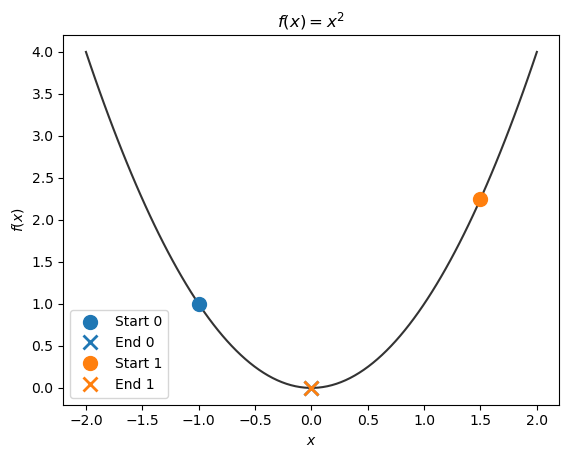

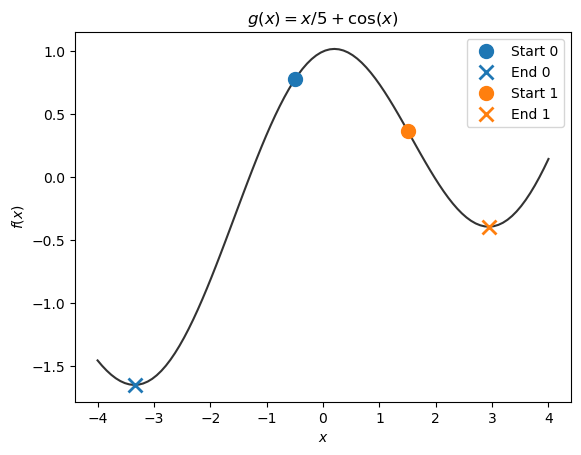

In [10]:
def plot_example_minimize_curve(xx, f, start_points, title=None):
  plt.plot(xx, f(xx), color=".2")
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  for i, x0 in enumerate(start_points):
    res = minimize(f, x0)
    plt.plot(x0, f(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
    plt.plot(res["x"].item(), res["fun"], "x", color=f"C{i}",
             ms=10, mew=2, label=f"End {i}")
  if title is not None:
    plt.title(title)
  plt.legend()
  plt.show()

f = np.square
res = minimize(f, x0=2)
print(f"Minimum value: {res['fun']:.4g} at x = {res['x'].item():.5e}")

start_points = -1, 1.5
xx = np.linspace(-2, 2, 100)
plot_example_minimize_curve(xx, f, start_points, title="$f(x) = x^2$")

g = lambda x: x / 5 + np.cos(x)
start_points = -.5, 1.5
xx = np.linspace(-4, 4, 100)
plot_example_minimize_curve(xx, g, start_points, title="$g(x) = x/5 + \\cos(x)$")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 2.2:</b>

Try implementing Poisson GLM. It might take some time to solve.

</div>

Hint:
- `fun`: returns the NLL given parameters `theta` and data `(X, y)` via `args`.
- `x0`: a vector of length `d` (number of parameters, including bias). Zeros or small Gaussian noise are common.
- `method`: quasi-Newton methods like `'BFGS'` or `'L-BFGS-B'` work well in practice; `'Newton-CG'` or `'trust-constr'` can benefit if you provide `jac`/`hess`.
- `jac`: if you supply the gradient, convergence is usually faster and more reliable. Otherwise SciPy will approximate it numerically.
- `options`: e.g., `{'maxiter': 1000, 'gtol': 1e-6}` to control iterations and tolerances.
- Return value: an `OptimizeResult` with fields like `.x` (parameters), `.fun` (objective), `.success`, `.nit` (iterations), `.message`.

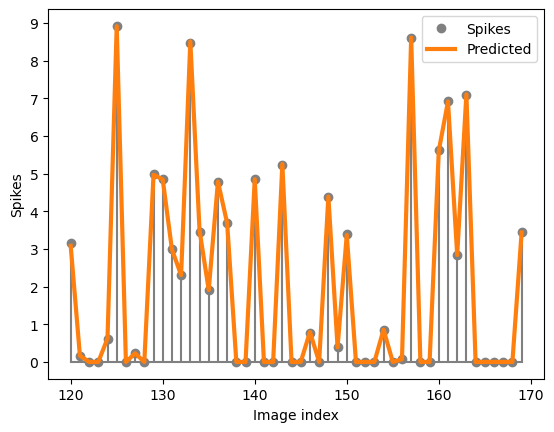

In [11]:
def predict_spike_counts_lnp(stim, spikes, theta=None):
  # Build the design matrix (with bias term)
  y = spikes
  # X = ... # Please add bias term # your code here
  X = np.column_stack([np.ones((len(y), 1)), make_design_matrix(stim)])

  # Use a random vector of weights to start (mean 0, sd .2)
  np.random.seed(0)
  x0 = np.random.normal(0, .2, X.shape[1])

  # Find parameters that minimize the negative log likelihood function
  # Hint: use the minimize function as minimize(func, x0, args=(...))
  # Hint: 'args' is the parameters of your function starting from the second one
  #       i.e. your fucntion is defined as func(theta, *args)
  # Hint: add '.x' to get the weights (theta) from the result
  # theta = ... # your code here
  theta = minimize(neg_log_lik_lnp, x0, args=(X, y)).x

  # Hint: yhat is the predicted lambda
  # yhat = ... # your code here
  yhat = np.exp(X @ theta)
  return yhat, theta


# Predict spike counts
yhat_lnp, theta_lnp = predict_spike_counts_lnp(stim_data, spike_data[:, neuron_id])

# Visualize
plot_spikes_with_prediction(spike_data[:, neuron_id], yhat_lnp,
                            nt=50, t0=120, color="C1")

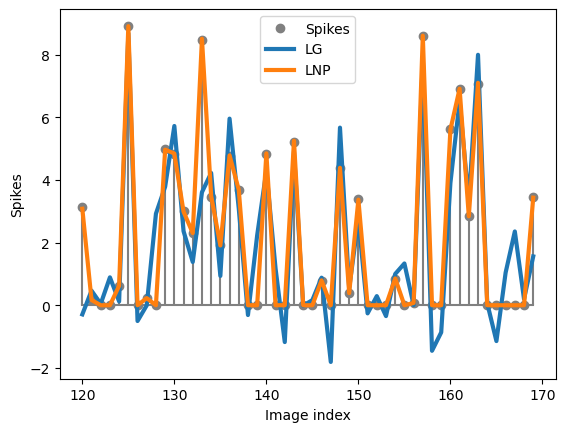

In [12]:
plot_spikes_with_multiple_predictions(
   spike_data[:, neuron_id], [yhat_lg, yhat_lnp],
   show=True, labels=["LG", "LNP"], colors=["C0", "C1"]
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f6f8d9ff; ">

**Bonus 1. Linear nonlinear Gaussian model**

Try implementing linear nonlinear Gaussian model. Please set the `method` argument of `minimize` to `L-BFGS-B`.

**Bonus of bonus**: try provide the method for computing the gradient vector as argument `jac` in `minimize` to improve the performance.

</div>

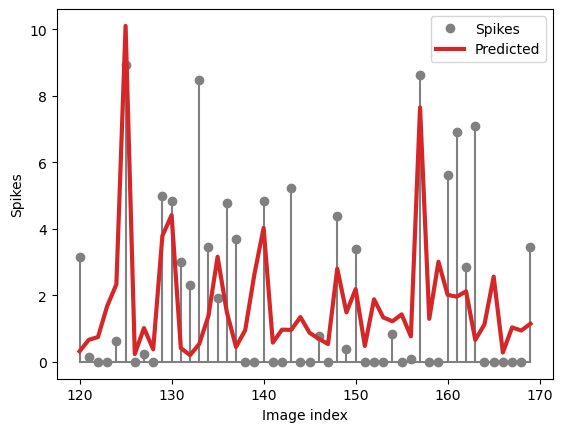

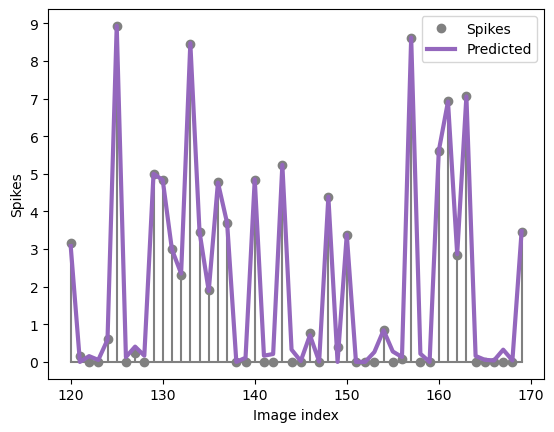

In [13]:
def neg_log_lik_lng(theta, X, y):
    # log_lik = ... # your code here
    log_lik = -0.5 * np.sum((y - np.exp(X @ theta)) ** 2)
    return -log_lik

def predict_spike_counts_lng(stim, spikes, theta=None):
    y = spikes
    # X = ... # your code here
    X = make_design_matrix(stim)
    np.random.seed(0)
    x0 = np.random.normal(0, .2, X.shape[1])
    # Set 'method=L-BFGS-B' in minimize() if not use jac
    # theta = ... # your code here
    theta = minimize(neg_log_lik_lng, x0, args=(X, y), method='L-BFGS-B').x
    yhat = np.exp(X @ theta)
    return yhat, theta

def grad_neg_log_lik_lng(theta, X, y):
    # Gradient of negative log likelihood w.r.t. θ
    # grad = ... # your code here (optional)
    y_pred = np.exp(X @ theta)
    residual_term = (y_pred - y) * y_pred
    grad = X.T @ residual_term
    return grad

def predict_spike_counts_lng_jac(stim, spikes, theta=None):
    y = spikes
    # X = ... # your code here
    X = make_design_matrix(stim)
    x0 = np.random.normal(0, .2, X.shape[1])
    # Bonus of bonus: Implement 'grad_neg_log_lik_log' to use 'jac' in minimize().
    theta = ... # your code here
    theta = minimize(neg_log_lik_lng, x0, args=(X, y),
                     method='L-BFGS-B', jac=grad_neg_log_lik_lng,).x
    yhat = np.exp(X @ theta)
    return yhat, theta


yhat_lng, theta_lng = predict_spike_counts_lng(stim_data, spike_data[:, neuron_id])
plot_spikes_with_prediction(spike_data[:, neuron_id], yhat_lng, nt=50, t0=120, color="C3")

# If you do not implemented 'grad_neg_log_lik_log', comment the two lines below
yhat_lng, theta_lng = predict_spike_counts_lng_jac(stim_data, spike_data[:, neuron_id])
plot_spikes_with_prediction(spike_data[:, neuron_id], yhat_lng, nt=50, t0=120, color="C4")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f6f8d9ff; ">

**Bonus 2. Thinking the selection of nonlinearity**

We use exponential nonlinearity in Poisson GLM. Can we use other nonlinearities, such as $\sin()$ as nonlinearity here? What if we use uniform distribution as nonlinearity?
</div>

# 3.Bernoulli GLM (Logistic Regression)

A Bernoulli Generalized Linear Model (GLM) is used for binary outcomes $y_i \in \{0,1\}$, e.g., spike/no-spike, success/failure, or yes/no decisions.

- **Linear predictor**: $\eta_i = \mathbf{x}_i^\top \boldsymbol{\theta} + b$ (features $\mathbf{x}_i$, weights $\boldsymbol{\theta}$, bias $b$)
- **Nonlinearity** (sigmoid, aka logistic): $\displaystyle p_i = \sigma(\eta_i) = \frac{1}{1 + e^{-\eta_i}}$ (This mapping guarantees $p_i \in (0,1)$ and yields a convex (well-behaved) optimization problem for maximum likelihood.)
- **Noise** (Bernoulli): $\Pr(y_i\mid p_i) = p_i^{y_i}(1-p_i)^{1-y_i}$

Negative log-likelihood (NLL), aka binary cross-entropy loss:  
$$\displaystyle \mathcal{L}_{\text{NLL}}(\boldsymbol{\theta}, b) = -\sum_{i} \Big[ y_i\,\log p_i + (1-y_i)\,\log(1-p_i) \Big]$$


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 3.1:</b>

Try implementing the logistic function, i.e. the sigmoid function.
</div>

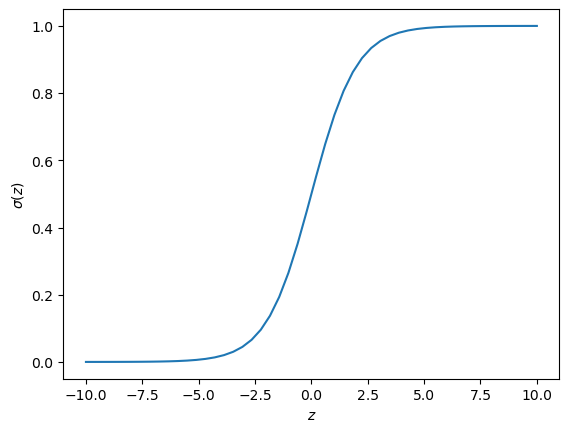

In [14]:
def sigmoid(z):
  # sigmoid = ... # your code here
  sigmoid = 1 / (1 + np.exp(-z))
  return sigmoid

# Visualize
plot_function(sigmoid, "\\sigma", "z", (-10, 10))

### (1) Prepare data

We use Bernoulli GLM to predict binary choices. Here we define the choices to be 'whether the specific neuron ever fires during a trial to a specific image'. We first sum up the spike counts across the entire trial (300ms), then average over trials, and finally check if the averaged total spike counts is greater than 0.

In [15]:
def collate_rgc_data_2(imagedata, spikedata,
                       images_id=None, neuron_id=5):
    stim_data = imagedata.reshape(303, 16, int(256/16), 16, int(256/16)).mean(axis=3).mean(axis=1).reshape(303, -1) # (303, 16*16)
    spike_data = spikedata # (156, 303, 13, 300)
    if images_id is None: images_id = np.arange(100, 150)
    stim_data = stim_data[images_id, :]  # (50, 16*16) by default
    spike_data = spike_data[neuron_id, images_id, :, :].sum(-1).mean(-1) # (50,) by default
    return stim_data, spike_data

stim_data, spike_data = collate_rgc_data_2(rgc_data['images'], rgc_data['spikes'])

print(f"stim_data.shape: {stim_data.shape}\nspike_data.shape: {spike_data.shape}")
choices = spike_data > 0
print(f"choices: {choices}")

stim_data.shape: (50, 256)
spike_data.shape: (50,)
choices: [ True  True  True False  True  True False False  True  True  True False
  True  True  True  True  True  True  True  True  True  True False False
  True  True False  True False  True  True  True  True  True  True  True
  True  True False False  True False False  True False False  True False
  True  True]


### (2) Solve Bernoulli GLM

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 3.2:</b>

Try implementing the accuracy calculating. The accuracy is defined as the proportion of correct predictions.
</div>

In [16]:
def compute_accuracy(y, yhat):
  # accuracy = ... # your code here
  accuracy = np.sum(yhat == y) / len(y)
  return accuracy

tmp_y = np.array([0, 1, 0, 1, 0, 1])
tmp_yhat = np.array([0, 0, 0, 1, 1, 1])
print(compute_accuracy(tmp_y, tmp_yhat))

0.6666666666666666


Here we directly use `sklearn.linear_model.LogisticRegression` (which is imported as `LogisticRegression` at the beginning of this tutorial) to perform logistic regression. Check its [document](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for more details.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 3.3:</b>

Try predicting the $\hat{y}$ using Bernoulli GLM i.e. LogisticRegression.
</div>

Accuracy on the training data: 100.00%


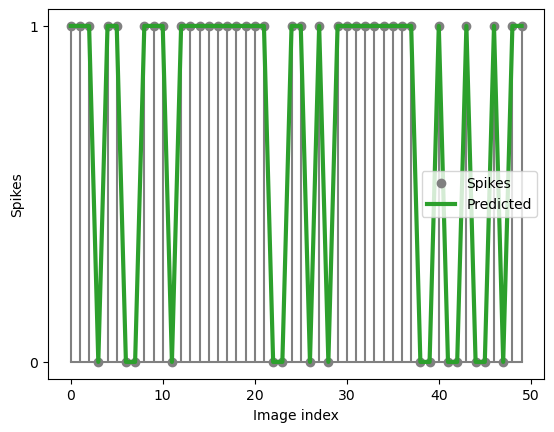

In [17]:
def predict_spike_counts_logistic(spikes, choices):
  # Build the design matrix (without bias term)
  X = spikes
  y = choices
  log_reg = LogisticRegression(penalty=None)
  log_reg.fit(X, y)

  # Compute predicted spike counts
  # Hint: use the .predict() method of the LogisticRegression class
  # yhat = ... # your code here
  yhat = log_reg.predict(X)
  return yhat

yhat_logistic = predict_spike_counts_logistic(stim_data, choices)
# Compute train accuracy
train_accuracy = compute_accuracy(choices, yhat_logistic)
print(f"Accuracy on the training data: {train_accuracy:.2%}")
# Visualize
plot_spikes_with_prediction(choices, yhat_logistic, nt=50, t0=0, color="C2")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f6f8d9ff; ">

**Bonus 3. Regularization**

##### (1) Cross validation

Classification accuracy on the training data is 100%! That might sound impressive, but you should recall from yesterday the concept of *overfitting*: the classifier may have learned something idiosyncratic about the training data. If that's the case, it won't have really learned the underlying data->decision function, and thus won't generalize well to new data.

To check this, we can evaluate the *cross-validated* accuracy.

`scikit-learn` offers a number of [helpful functions](https://scikit-learn.org/stable/model_selection.html), we can cross-validate a classifier using `cross_val_score`. It takes a `sklearn` model like `LogisticRegression`, as well as your `X` and `y` data. It then retrains your model on test/train splits of `X` and `y`, and returns the test accuracy on each of the test sets.

</div>

<div>
<img src="http://kordinglab.com/images/others/justCV-01.png", width="900"/>
</div>

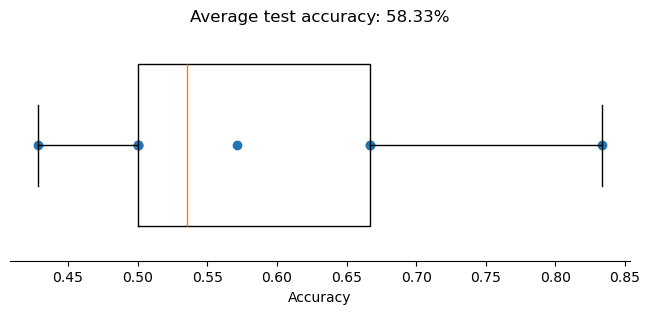

In [18]:
# cross-validation
accuracies = cross_val_score(LogisticRegression(penalty=None),
                             stim_data, choices, cv=8)  # k=8 cross validation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f6f8d9ff; ">

##### (2) $L_2$ regularization

Regularization comes in different flavors. A very common one uses an $L_2$ or "ridge" penalty. This changes the objective function to

$$
-\log\mathcal{L}'(\theta | X, y)= -\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i\theta_i^2,
$$

where $\beta$ is a *hyperparameter* that sets the *strength* of the regularization.

You can use regularization in `scikit-learn` by changing the `penalty`, and you can set the strength of the regularization with the `C` hyperparameter ($C = \frac{1}{\beta}$, so this sets the *inverse* regularization).

</div>

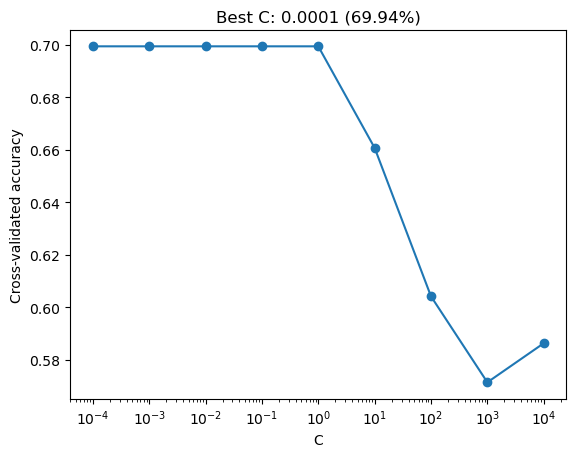

In [19]:
def model_selection(X, y, C_values):
  accuracies = []
  for C in C_values:
    # model = ... # your code here
    # accs = ... # your code here
    # accuracies.append(...) # your code here
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)
    accs = cross_val_score(model, X, y, cv=8)
    accuracies.append(accs.mean())
  return accuracies

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)
# Compute accuracies
accuracies = model_selection(stim_data, choices, C_values)
# Visualize
plot_model_selection(C_values, accuracies)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f6f8d9ff; ">

##### (3) $L_1$ regularization

$L_2$ is not the only option for regularization. There is also the $L_1$, or "Lasso" penalty. This changes the objective function to

$$
-\log\mathcal{L}'(\theta | X, y) = -\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i|\theta_i|
$$

In practice, using the summed absolute values of the weights causes *sparsity*: instead of just getting smaller, some of the weights will get forced to $0$:

</div>

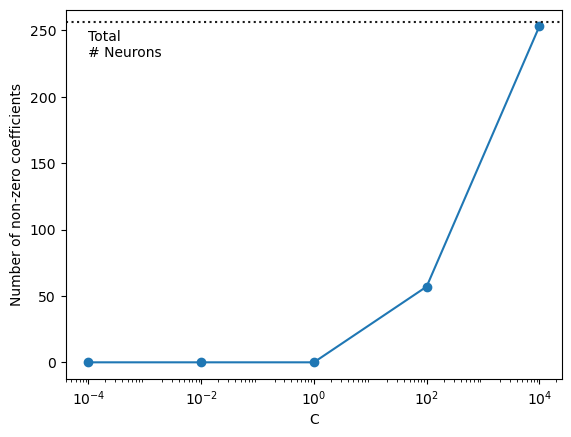

In [20]:
def count_non_zero_coefs(X, y, C_values):
  non_zero_coefs = []
  for C in C_values:
    # model = ... # your code here
    # ... # your code here
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X, y)
    # Get the coefs of the fit model (in sklearn, we can do this using model.coef_)
    # coefs = ... # your code here
    coefs = model.coef_
    # Count the number of non-zero elements in coefs
    # non_zero = ... # your code here
    non_zero = np.count_nonzero(coefs)
    non_zero_coefs.append(non_zero)
  return non_zero_coefs

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)
# Count non zero coefficients
non_zero_l1 = count_non_zero_coefs(stim_data, choices, C_values)
# Visualize
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=stim_data.shape[1])

## 4.GLM with Post-Spike (History) Filter

A GLM with a post-spike (history) filter augments standard stimulus-driven models by letting recent spikes influence the current firing probability/rate. This captures refractoriness, bursting, and spike-frequency adaptation observed in neurons.

### (1) Prepare data

In [21]:
def collate_rgc_data_3(imagedata, spikedata,
                       image_id=100, neuron_id=5):
    stim_data = imagedata.reshape(303, 16, int(256/16), 16, int(256/16)).mean(axis=3).mean(axis=1).reshape(303, -1) # (303, 16*16)
    spike_data = spikedata # (156, 303, 13, 300)
    T = spike_data.shape[-1]
    stim_data = np.tile(stim_data[image_id, :], (T, 1))  # (300, 16*16) by default
    spike_data = spike_data[neuron_id, image_id, :, :].mean(0) # (300,) by default
    return stim_data, spike_data

stim_data, spike_data = collate_rgc_data_3(rgc_data['images'], rgc_data['spikes'])
print(stim_data.shape, spike_data.shape)

(300, 256) (300,)


### (2) Construct spike history

To add spike history into the model, we just need to modify the linear part of GLM to
$$\eta_t = \mathbf{x}_t^\top \boldsymbol{\theta} + \mathbf{h}^\top \mathbf{H}_t + b$$
- $\mathbf{x}_t$: stimulus/features at time $t$
- $\mathbf{H}_t$: spike history vector $[y_{t-1},\dots,y_{t-K}]^\top$
- $\mathbf{h}$: post-spike (history) filter weights, $b$: bias

**Interpretation of the post-spike filter $\mathbf{h}$**
- Strong negative weights at very short lags (1–5 ms): absolute/relative refractory period.
- Positive bump at short lags (e.g., 5–20 ms): burst propensity.
- Slow negative tail (tens–hundreds of ms): spike-frequency adaptation.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 4.1:</b>

Try building the history term $\mathbf{H}_t$.

</div>

In [22]:
def make_post_spike_matrix(spikes, n_history_bins):
    '''
    Construct a matrix of post-spike history terms.
    spikes: (T,) array of spike counts (0 or 1 for simplicity)
    n_history_bins: number of bins for spike history
    Returns:
        H: (T, n_history_bins) matrix, each column is spike count at lag k
    '''
    T = len(spikes)
    H = np.zeros((T, n_history_bins))
    # ... # your code here
    for k in range(1, n_history_bins+1):
        H[k:, k-1] = spikes[:-k]
    return H

H = make_post_spike_matrix(spike_data, n_history_bins=10)
print(H.sum())

63.07692307692308


### (3) Develop Poisson GLM with post spike filter

**Discrete-time Bernoulli-GLM (logistic nonlinearity)**
- Nonlinearity: $p_t = \sigma(\eta_t) = \frac{1}{1 + e^{-\eta_t}}$
- Log-likelihood: $\displaystyle \log \mathcal{L} = \sum_t \big[ y_t\,\log p_t + (1-y_t)\,\log(1-p_t) \big]$
- Output: binary spike indicator per bin ($y_t \in \{0,1\}$)

**Point-process / Poisson-GLM (exp nonlinearity)**
- Nonlinearity: $\exp(\eta_t)$
- Log-likelihood: $\displaystyle \log \mathcal{L} = \sum_t \big[ y_t \log \lambda_t - \lambda_t\,\Delta - \log(y_t!) \big]$
- Output: spike counts per bin ($y_t \sim \mathrm{Poisson}(\lambda_t\,\Delta)$)

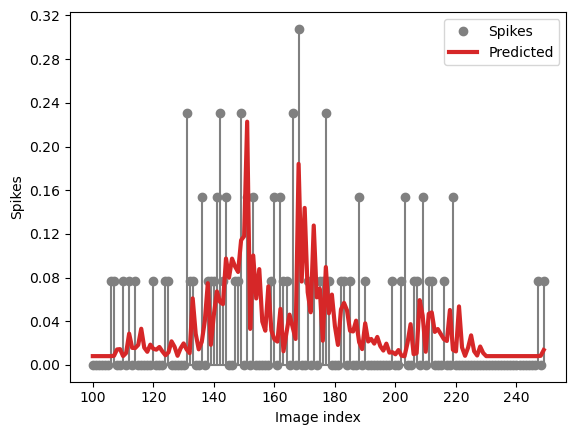

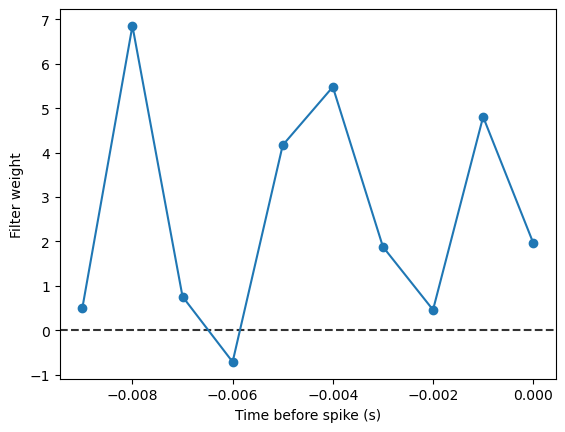

In [23]:
def neg_log_lik_poisson_with_history(theta, X, y):
    # neg_log_lik = ... # your code here
    neg_log_lik = neg_log_lik_lnp(theta, X, y)
    return neg_log_lik

def fit_glm_with_post_spike_filter(stim_data, spike_data, n_history_bins=10):
    '''
    Fit a Poisson GLM with post-spike filter.
    Returns: predicted firing rate, fitted parameters, and post-spike filter matrix.
    '''
    y = spike_data

    # Construct post-spike history matrix
    # H = ... # your code here
    H = make_post_spike_matrix(y, n_history_bins)
    # Design matrix: stimulus + post-spike history
    # X = ... # your code here
    X = np.column_stack([np.ones_like(y), make_design_matrix(stim_data), H])

    np.random.seed(0)
    x0 = np.random.normal(0, 0.2, X.shape[1])
    theta = minimize(neg_log_lik_poisson_with_history, x0, args=(X, y), method='BFGS').x
    yhat = np.exp(X @ theta)
    return yhat, theta


n_history_bins = 10
yhat, theta = fit_glm_with_post_spike_filter(stim_data, spike_data, n_history_bins)
# Visualize
plot_spikes_with_prediction(spike_data, yhat, nt=150, t0=100, color="C3")
plot_spike_filter(theta[-n_history_bins:], dt=rgc_data['resolution'])